Каждый пункт, который предлагается выполнить в рамках домашнего задания, имеет объявленную "цену" в баллах. Максимально возможная сумма – 10 баллов, а с учётом бонусных пунктов – 12 баллов. Выполнять все пункты не обязательно, можно сделать только часть. В большинстве пунктов ожидается, что вы напишете работающий код на Python; иногда надо будет писать комментарии в свободной форме – например, сравнивать несколько подходов к решению одной задачи. Там, где оставлены пустые клетки под ваши ответы, вы можете по своему усмотрению добавлять ещё клетки.

* * *

Эта лабораторная работа посвящена кластеризации. Мы будем работать с рукописными изображениями цифр, научимся их кластеризовать двумя разными методами (иерархическая кластеризация и алгоритм $K$-means), оценивать качество разбиения и выбирать оптимальное число кластеров, а также визуализировать промежуточные результаты.

# 1. Получение данных

Данные, с которыми мы будем работать, доступны в библиотеке scikit-learn (модуль называется `sklearn`) в подмодуле `datasets` через функцию, которая называется `load_digits`. Всего имеется 1797 наблюдений, каждое из них представляет чёрно-белую картинку 8 $\times$ 8 пикселей. Эти картинки – распознанные рукописные цифры от 0 до 9. Образцов написания каждой цифры дано приблизительно поровну, около 180.

Для удобства использования данных каждая картинка "развёрнута" в строку, так что NumPy-массив, в котором хранятся данные, имеет размерность 2 и величину 1797 $\times$ 64 (а не, например, размерность 3 и величину 1797 $\times$ 8 $\times$ 8). Интенсивность цвета в каждом пикселе кодируется целым числом от 0 до 16.

Кроме наблюдений (картинок), известны соответствующие им значения целевой переменной: какую цифру на самом деле изображает каждая картинка. Мы могли бы сразу сформулировать задачу обучения с учителем и предсказывать цифры по картинкам, но для целей этой лабораторной работы мы будем действовать по-другому: сделаем вид, что нам не известны истинные метки классов (т. е. цифры) и даже количество классов, и попробуем сгруппировать данные таким образом, чтобы качество кластеризации оказалось наилучшим, а затем посмотрим, насколько точно полученные кластеры совпадают с группами изображений одинаковых цифр.

**(0.5 балла)** Загрузите данные. Добейтесь, чтобы в переменной `X` оказался массив наблюдений, содержащий 1797 $\times$ 64 числа, а в переменной `y` – массив истинных меток классов, содержащий 1797 чисел.

*Указания:*
- Как загрузить данные, объяснено в справке к функции `load_digits`.
- Размер массива хранится в атрибуте `shape`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score, v_measure_score
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

np.random.seed(1)
sns.set(font_scale=1.2)

In [2]:
digits = load_digits()
X, y = digits.data, digits.target
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1797, 64)
y shape: (1797,)


**(1 балл)** Визуализируйте первые десять картинок, расположив их на сетке 3 $\times$ 4 (в последнем ряду останутся пустые места). Добейтесь, чтобы фон картинок был белым, а изображения цифр – тёмными.

*Указания:*
- Не забудьте импортировать NumPy и Matplotlib.
- Картинки 8 $\times$ 8 можно либо достать готовыми из объекта, загруженного функцией `load_digits`, либо сделать самостоятельно из строк массива `X`. Во втором случае пользуйтесь методом `reshape`.
- Чтобы изображение не было цветным, можно вызвать функцию `plt.gray`, прежде чем начать рисовать.
- Располагать картинки на сетке умеет функция `plt.subplot`. Ознакомьтесь со справкой к ней.
- По умолчанию число 0 кодирует чёрный цвет, а число 16 – белый цвет. Подумайте, как обратить цвета одной операцией над NumPy-массивом.
- Выводить картинку на экран умеет функция `plt.imshow`. Ознакомьтесь со справкой к ней.
- Если считаете нужным, можете отключить сглаживание – параметр `interpolation` у функции `plt.imshow`.
- Если считаете нужным, можете отключить деления на координатных осях. За это отвечают функции `plt.xticks` и `plt.yticks`.

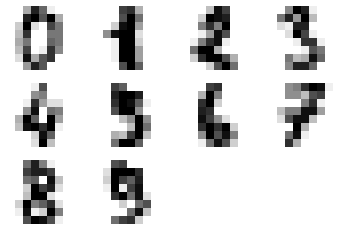

In [3]:
for index, (image, label) in enumerate(zip(digits.data[0:10], digits.target[0:10])):
    plt.subplot(3, 4, index + 1)
    plt.imshow(np.reshape(image, (8,8)), cmap='gray_r')
    plt.axis('off')

# 2. Кластеризация и оценка качества

Мы будем использовать два популярных алгоритма: иерархическую кластеризацию и метод $K$ средних ($K$-means clustering). Эти и другие алгоритмы кластеризации доступны в библиотеке scikit-learn в подмодуле `cluster`. Иерархическая кластеризация называется `AgglomerativeClustering`, а метод $K$ средних – `KMeans`.

Интерфейс у большинства алгоритмов в scikit-learn простой и единообразный:
- Чтобы инициализировать модель, нужно создать экземпляр соответствующего класса со всеми необходимыми параметрами. Например, у кластеризаций единственный обязательный параметр называется `n_clusters`, это количество кластеров, которое мы хотим получить на выходе.
- Инициализированную модель можно обучить, вызвав метод `fit`.
- С помощью обученной модели можно предсказывать, вызывая метод `predict`.

Как видно, этот интерфейс хорош только для задач обучения с учителем, в которых чётко разделены фазы обучения модели и предсказания с её помощью. У кластеризаций зато есть метод `fit_predict`, который разбивает входную выборку на кластеры и сразу же возвращает результаты разбиения.

**(0.5 балла)** Используя каждый из двух методов, иерархическую кластеризацию и $K$ средних, получите разбиение массива `X` на 10 кластеров.

*Указания:*
- Оба раза должен получиться массив из 1797 чисел – номеров кластеров.
- `KMeans` делает несколько (по умолчанию 10) запусков со случайными центрами и из полученных разбиений выводит лучшее в терминах среднего внутрикластерного расстояния. Чтобы улучшить качество предсказаний, можно увеличить число запусков, например, до 100. Это параметр `n_init` в конструкторе.

In [4]:
ac_model = AgglomerativeClustering(n_clusters=10)
ac_labels = ac_model.fit_predict(X)
print(f"AgglomerativeClustering: {ac_labels.shape}")

kmeans_model = KMeans(n_clusters=10, random_state=0)
kmeans_labels = kmeans_model.fit_predict(X)
print(f"KMeans: {kmeans_labels.shape}")

AgglomerativeClustering: (1797,)
KMeans: (1797,)


**(1 балл)** Визуализируйте центры кластеров, полученных каждым из двух способов. Это опять должны быть картинки на сетке 3 $\times$ 4 с белым фоном и тёмными контурами. Прокомментируйте: какой из двух алгоритмов даёт центры кластеров, больше похожие на типичные начертания цифр?

*Указания:*
- Центр кластера – это среднее по всем наблюдениям, входящим в кластер, т. е. по какому-то набору строк из `X`.
- Чтобы выбрать наблюдения, входящие в кластер номер `i`, используйте индексацию по булевозначной маске. Саму маску можно получить из массива предсказанных номеров кластеров и числа `i` оператором `==`.
- Усреднять NumPy-массив вдоль какой-нибудь из осей умеет функция `np.mean`. Ознакомьтесь со справкой к ней. Нам нужно усреднение по строкам.

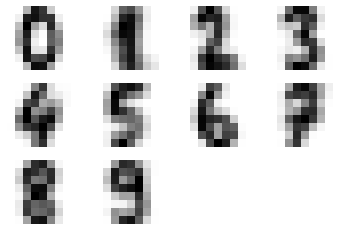

In [5]:
for index, label in enumerate(np.unique(ac_labels)):
    plt.subplot(3, 4, index + 1)
    plt.imshow(np.reshape(digits.data[digits.target == label].mean(axis=0), (8,8)), cmap='gray_r')
    plt.axis('off')
    

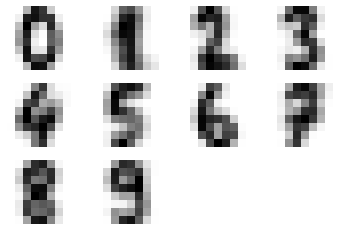

In [6]:
for index, label in enumerate(np.unique(kmeans_labels)):
    plt.subplot(3, 4, index + 1)
    plt.imshow(np.reshape(digits.data[digits.target == label].mean(axis=0), (8,8)), cmap='gray_r')
    plt.axis('off')
    

**Summary:** Both KMeans and AgglomerativeClustering give a similar result, but the original images look sharper. 

В ситуации, когда истинное число кластеров неизвестно, подбирают оптимальное число кластеров. При этом учитывают две величины: внутрикластерное расстояние (чем меньше, тем лучше) и межкластерное расстояние (чем больше, тем лучше). Так как две эти величины не достигают оптимума одновременно, обычно оптимизируют какой-нибудь функционал от них. Один популярный функционал называется "силуэт" (silhouette). Вот как он вычисляется.

Пусть $X$ – множество наблюдений, $M \subset X$ – один из кластеров, на которые оно разбито в результате кластеризации, $\rho$ – метрика на $X$. Выберем какое-нибудь одно наблюдение $x \in M$. Обозначим $a(x)$ среднее расстояние от $x$ до точек $x'$ из того же кластера:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Обозначим $b(x)$ минимум средних расстояний от $x$ до точек $x''$ из какого-нибудь другого кластера $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

Силуэт – это разность межкластерного и внутрикластерного расстояний, нормированная до отрезка $[-1,\, 1]$ и усреднённая по всем наблюдениям:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

В scikit-learn силуэт считается функцией `silhouette_score` из подмодуля `metrics`. На вход нужно передать массив наблюдений и результат кластеризации.

**(1.5 балла)** Для числа $K$ от 2 до 20 включительно получите разбиение массива `X` на $K$ кластеров каждым из двух методов. Посчитайте силуэт. Посчитанные значения силуэта сохраните в переменную и визуализируйте в виде графика в координатах: число $K$ – значение силуэта. При каком числе кластеров достигается максимум силуэта?

*Указания:*
- Не забудьте, что функция `range` не захватывает правый конец диапазона.
- Под значения силуэта можно завести два списка: один для иерархической кластеризации, другой для $K$ средних.
- Рисовать графики умеет функция `plt.plot`. Ознакомьтесь со справкой к ней.
- На одной картинке можно разместить несколько графиков, это просто несколько последовательных вызовов `plt.plot`.
- Чтобы добавить легенду (подписи к графикам), можно воспользоваться функцией `plt.legend`. Местоположение легенды контролируется параметром `loc`.
- Чтобы подписать координатные оси, можно воспользоваться функциями `plt.xlabel` и `plt.ylabel`.

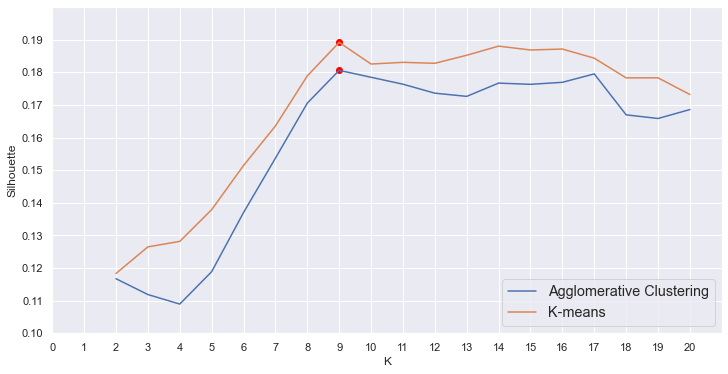

Maximum silhouette for agglomerative clustering: {'score': 0.18061975703867697, 'K': 9}
Maximum silhouette for K-means: {'score': 0.1891928164889673, 'K': 9}


In [7]:
silhouette_aggl_clus = []
silhouette_k_means = []
max_sil_aggl_clus = {'score': 0, 'K': 0}
max_sil_k_means = {'score': 0, 'K': 0}
for K in range(2,21):
    y_pred_aggl_clus = AgglomerativeClustering(n_clusters=K).fit_predict(X)
    current_score = silhouette_score(X, y_pred_aggl_clus)
    silhouette_aggl_clus.append(current_score)
    if current_score > max_sil_aggl_clus['score']:
        max_sil_aggl_clus['score'] = current_score
        max_sil_aggl_clus['K'] = K
    
    y_pred_k_means = KMeans(n_clusters=K, n_init=100, random_state=42).fit_predict(X)
    current_score = silhouette_score(X, y_pred_k_means)
    silhouette_k_means.append(current_score)
    if current_score > max_sil_k_means['score']:
        max_sil_k_means['score'] = current_score
        max_sil_k_means['K'] = K

plt.figure(figsize=(12, 6))    
plt.plot(range(2,21), silhouette_aggl_clus, label='Agglomerative Clustering')
plt.plot(range(2,21), silhouette_k_means, label='K-means')
plt.scatter(max_sil_aggl_clus['K'], max_sil_aggl_clus['score'], c='red')
plt.scatter(max_sil_k_means['K'], max_sil_k_means['score'], c='red')
plt.xlabel('K')
plt.ylabel('Silhouette')
plt.xlim(0, 21)
plt.ylim(0.1, 0.2)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0.1, 0.2, 0.01))
plt.legend(loc='lower right', fontsize='large')
plt.show()

print(f'Maximum silhouette for agglomerative clustering: {max_sil_aggl_clus}')
print(f'Maximum silhouette for K-means: {max_sil_k_means}')

**Summary:** The maximum silhouette is achieved when the number of clusters is equal to nine.

Когда известно "правильное" (в каком-нибудь смысле) разбиение на кластеры, результат кластеризации можно сравнить с ним, используя такие меры, как однородность (homogeneity), полнота (completeness) и их среднее гармоническое – $V$-мера. Определения этих величин довольно громоздкие и основаны на понятии [энтропии распределения вероятностей](https://ru.wikipedia.org/wiki/Информационная_энтропия); подробности излагаются в [этой статье](http://aclweb.org/anthology/D/D07/D07-1043.pdf). На практике достаточно знать, что однородность, полнота и $V$-мера заключены между нулём и единицей – чем больше, тем лучше.

Так как мы знаем, какую цифру на самом деле изображает каждая картинка (это массив `y`), мы можем использовать однородность, полноту и $V$-меру для оценки качества кластеризации. Функции для вычисления этих величин доступны в scikit-learn, в подмодуле `metrics`, под названиями `homogeneity_score`, `completeness_score`, `v_measure_score`. Как вариант, можно использовать функцию `homogeneity_completeness_v_measure`, которая возвращает сразу тройку чисел.

**(1 балл)** Повторите предыдущее задание, используя $V$-меру вместо силуэта. При каком числе кластеров достигается максимум $V$-меры?

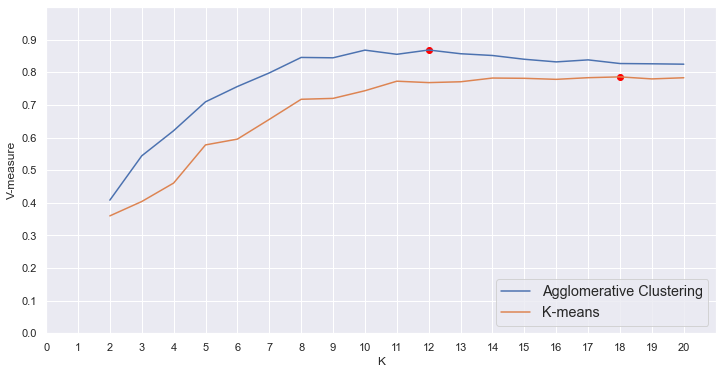

Maximum V-measure for agglomerative clustering: {'score': 0.86854875186737, 'K': 12}
Maximum V-measure for K-means: {'score': 0.7861749886360692, 'K': 18}


In [8]:
v_measure_aggl_clus = []
v_measure_k_means = []
max_v_measure_aggl_clus = {'score': 0, 'K': 0}
max_v_measure_k_means = {'score': 0, 'K': 0}
for K in range(2,21):
    y_pred_aggl_clus = AgglomerativeClustering(n_clusters=K).fit_predict(X)
    current_score = v_measure_score(y, y_pred_aggl_clus)
    v_measure_aggl_clus.append(current_score)
    if current_score > max_v_measure_aggl_clus['score']:
        max_v_measure_aggl_clus['score'] = current_score
        max_v_measure_aggl_clus['K'] = K
    
    y_pred_k_means = KMeans(n_clusters=K, n_init=100, random_state=42).fit_predict(X)
    current_score = v_measure_score(y, y_pred_k_means)
    v_measure_k_means.append(current_score)
    if current_score > max_v_measure_k_means['score']:
        max_v_measure_k_means['score'] = current_score
        max_v_measure_k_means['K'] = K

plt.figure(figsize=(12, 6))    
plt.plot(range(2,21), v_measure_aggl_clus, label='Agglomerative Clustering')
plt.plot(range(2,21), v_measure_k_means, label='K-means')
plt.scatter(max_v_measure_aggl_clus['K'], max_v_measure_aggl_clus['score'], c='red')
plt.scatter(max_v_measure_k_means['K'], max_v_measure_k_means['score'], c='red')
plt.xlabel('K')
plt.ylabel('V-measure')
plt.xlim(0, 21)
plt.ylim(0, 1)
plt.xticks(np.arange(0, 21, 1))
plt.yticks(np.arange(0, 1, 0.1))
plt.legend(loc='lower right', fontsize='large')
plt.show()

print(f'Maximum V-measure for agglomerative clustering: {max_v_measure_aggl_clus}')
print(f'Maximum V-measure for K-means: {max_v_measure_k_means}')

**Summary:** The maximum 𝑉-measure for hierarchical clustering is achieved at K = 12, for K-means at K = 18. 

# 3. Снижение размерности признакового пространства

Иногда, особенно когда признаков много и не все они одинаково информативные, бывает полезно снизить размерность признакового пространства, то есть вместо $d$ исходных признаков перейти к рассмотрению $d' \ll d$ новых признаков. Данные были представлены матрицей $n$ наблюдений $\times$ $d$ исходных признаков, а теперь будут представлены матрицей $n$ наблюдений $\times$ $d'$ новых признаков.

Есть два популярных подхода к снижению размерности:
- отобрать (select) новые признаки из числа имеющихся;
- извлечь (extract) новые признаки, преобразуя старые, например, сделать $d'$ различных линейных комбинаций столбцов исходной матрицы $n \times d$.

Одним из широко используемых методов извлечения признаков является сингулярное разложение матрицы (singular value decomposition, SVD). Этот метод позволяет сконструировать любое число $d' \le d$ новых признаков таким образом, что они будут, в определённом смысле, максимально информативными. Математические детали сейчас не важны; познакомиться с ними можно, например, [здесь](https://www.coursera.org/learn/mathematics-and-python/lecture/L9bCV/razlozhieniia-matrits-v-proizviedieniie-singhuliarnoie-razlozhieniie)
(по-русски) или [здесь](https://www.youtube.com/watch?v=P5mlg91as1c) (по-английски).

В scikit-learn есть несколько реализаций сингулярного разложения. Мы будем использовать класс `TruncatedSVD` из подмодуля `decomposition`. В конструктор этого класса достаточно передать один параметр `n_components` – желаемое число новых признаков. Метод `fit_transform` принимает матрицу и возвращает новую матрицу с таким же количеством строк, как прежде, и количеством столбцов, равным числу новых признаков.

<u>Замечание:</u> Сингулярное разложение матрицы $M$ обычно пишут в виде $M = U \Sigma V^{*}$, где $U$, $\Sigma$ и $V$ – некие матрицы с хорошими свойствами. То, что возвращает алгоритм `TruncatedSVD`, – это сколько-то (сколько мы хотим получить) первых столбцов матрицы $U$.

**(1.5 балла)** Выполните сингулярное разложение матрицы `X`, оставляя 2, 5, 10, 20 признаков. В каждом случае выполните иерархическую и $K$-means кластеризацию преобразованных данных (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли при каком-нибудь $d'$ получить силуэт и / или $V$-меру лучше, чем на исходных данных?

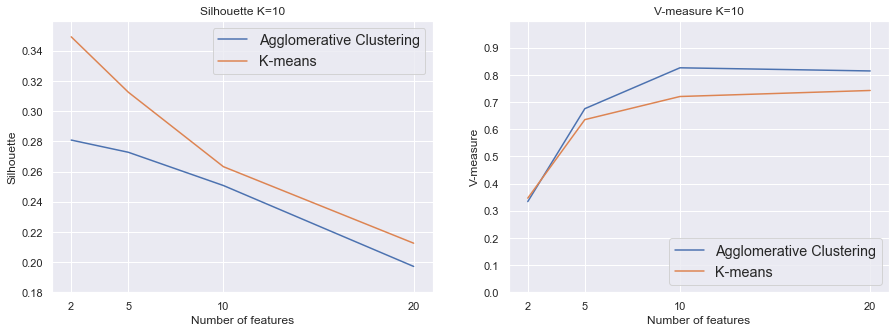

In [9]:
silhouette_aggl_clus = []
silhouette_k_means = []
v_measure_aggl_clus = []
v_measure_k_means = []
for n_features in [2, 5, 10, 20]:
    X_transformed = TruncatedSVD(n_components=n_features, random_state=42).fit_transform(X)
    y_pred_aggl_clus = AgglomerativeClustering(n_clusters=10).fit_predict(X_transformed)
    silhouette_aggl_clus.append(silhouette_score(X_transformed, y_pred_aggl_clus))
    v_measure_aggl_clus.append(v_measure_score(y, y_pred_aggl_clus))
    y_pred_k_means = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(X_transformed)
    silhouette_k_means.append(silhouette_score(X_transformed, y_pred_k_means))
    v_measure_k_means.append(v_measure_score(y, y_pred_k_means))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot([2, 5, 10, 20], silhouette_aggl_clus, label='Agglomerative Clustering')
ax1.plot([2, 5, 10, 20], silhouette_k_means, label='K-means')
ax1.set(xlabel='Number of features', ylabel='Silhouette')
ax1.set_title('Silhouette K=10')
ax1.set(xlim=(1, 21), ylim=(0.18, 0.36))
ax1.set_xticks([2, 5, 10, 20])
ax1.set_yticks(np.arange(0.18, 0.36, 0.02))
ax1.legend(loc='upper right', fontsize='large')

ax2.plot([2, 5, 10, 20], v_measure_aggl_clus, label='Agglomerative Clustering')
ax2.plot([2, 5, 10, 20], v_measure_k_means, label='K-means')
ax2.set(xlabel='Number of features', ylabel='V-measure')
ax2.set_title('V-measure K=10')
ax2.set(xlim=(1, 21), ylim=(0, 1))
ax2.set_xticks([2, 5, 10, 20]);
ax2.set_yticks(np.arange(0, 1, 0.1))
ax2.legend(loc='lower right', fontsize='large');

**Summary:** Better values have been obtained for the silhouette. For the V-measure, the values deteriorated slightly.

Другая популярная техника снижения размерности, которая особенно хорошо подходит для работы с картинками, – это алгоритм t-distributed stochastic neighbor embeddings, сокращённо tSNE. В отличие от сингулярного разложения, это преобразование нелинейное. Его основная идея – отобразить точки из пространства размерности $d$ в пространство размерности 2 или 3 (обычно 2, то есть на плоскость) таким образом, чтобы как можно точнее сохранить расстояния. Математические детали есть, например, [здесь](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), но они нетривиальны.

В библиотеке scikit-learn реализацией tSNE является класс `TSNE` в подмодуле `manifold`. В конструктор можно передать параметр `n_components`, а можно и не передавать: по умолчанию он равен 2. Метод `fit_transform` работает аналогично тому, как и у `TruncatedSVD`.

<u>Замечание:</u> В последние годы вместо tSNE на практике часто используется [UMAP](https://github.com/lmcinnes/umap), более быстрый алгоритм с похожими свойствами. В этой лабораторной работе не предлагается использовать UMAP, так как это потребовало бы установить ещё одну зависимость -- библиотеку `umap-learn`. Желающие могут проделать задания на tSNE с использованием UMAP; в этом случае обратите внимание на параметры `n_neighbors` и `min_dist`, которыми определяется вид проекции.

**(0.5 балла)** Выполните tSNE-преобразование матрицы `X`, оставив 2 признака. Визуализируйте данные, преобразованные таким образом, в виде точечной диаграммы: первый признак вдоль горизонтальной оси, второй признак вдоль вертикальной оси. Подсветите разными цветами группы точек, соответствующих разным цифрам.

*Указания:*
- Точечную диаграмму умеет рисовать функция `plt.scatter`. Ознакомьтесь со справкой к ней.
- За цвета точек отвечает параметр `c` у функции `plt.scatter`. Передать в него надо истинные метки классов.

In [10]:
reduced_data_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)

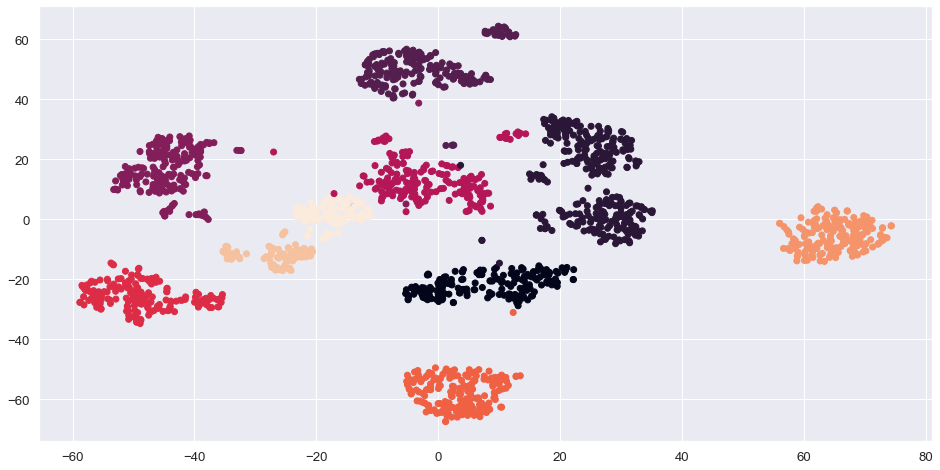

In [11]:
plt.figure(figsize=(16, 8))
plt.scatter(reduced_data_tsne[:, 0], reduced_data_tsne[:, 1], c=ac_labels)
plt.show()

**(1 балл)** Для tSNE-преобразованных данных с 2 признаками выполните иерархическую и $K$-means кластеризацию (число кластеров примите равным 10). Посчитайте значения силуэта и $V$-меры. Удалось ли получить силуэт и / или $V$-меру лучше, чем на исходных данных?

In [12]:
X_transformed = TSNE(random_state=42).fit_transform(X)

y_pred_aggl_clus = AgglomerativeClustering(n_clusters=10).fit_predict(X_transformed)
print(f'Silhouette score for agglomerative clustering (K=10): {silhouette_score(X_transformed, y_pred_aggl_clus)}')
print(f'V-measure score for agglomerative clustering (K=10): {v_measure_score(y, y_pred_aggl_clus)}')
y_pred_k_means = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(X_transformed)
print(f'Silhouette score for K-means (K=10): {silhouette_score(X_transformed, y_pred_k_means)}')
print(f'V-measure score for K-means (K=10): {v_measure_score(y, y_pred_k_means)}')

Silhouette score for agglomerative clustering (K=10): 0.6421834230422974
V-measure score for agglomerative clustering (K=10): 0.9111471953871231
Silhouette score for K-means (K=10): 0.6432376503944397
V-measure score for K-means (K=10): 0.9137798316714034


**Summary:** The V-measure and silhouette values obtained after applying TSNE, both for K means and for hierarchical clustering, are significantly higher than those obtained earlier.

**(0.5 балла)** Для самого лучшего разбиения, которое вам удалось получить (на ваше усмотрение, лучшего в терминах силуэта или $V$-меры), опять визуализируйте картинками центры кластеров. Удалось ли добиться, чтобы каждый кластер соответствовал какой-нибудь одной цифре?

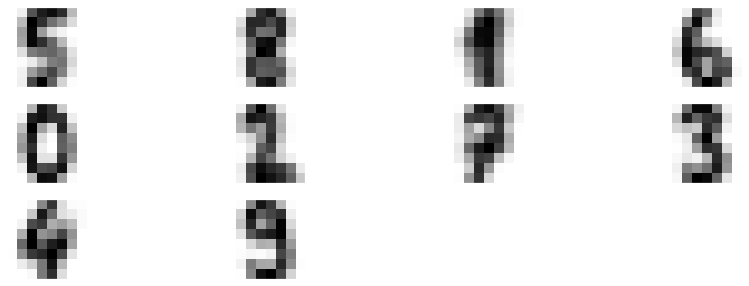

In [13]:
# Выбираем К-средних после применения TSNE преобразования данных
X_transformed = TSNE(random_state=42).fit_transform(X)
y_pred = KMeans(n_clusters=10, n_init=100, random_state=42).fit_predict(X_transformed)
centers = []
for i in range(0, 10):
    centers.append(np.mean(X[y_pred == i], axis=0))
plot_graph(centers)

**Summary:** Cluster images have become more distinguishable than in the first versions.

# 4. Итоги, бонус

**(1 балл)** Напишите в свободной форме, какие выводы вы сделали из выполненной работы. Ответьте, как минимум, на следующие два вопроса:
- Какой из двух методов даёт более осмысленные кластеры – иерархическая кластеризация или алгоритм $K$ средних? Зависит ли это от настроек каждого алгоритма? От критериев оценивания качества?
- Удаётся ли улучшить качество кластеризации, снижая размерность признакового пространства?

**Summary:**
- Both clustering methods show approximately the same results. 
- When using different metrics to assess the quality of clustering, there was no clear advantage in one of the methods. 
- The use of the method of reducing the dimensionality of the feature space helped to slightly improve the quality of clustering.

**(Бонусные 2 балла)** Скачайте датасет [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist). Как сделать это с помощью scikit-learn, написано [здесь](https://stackoverflow.com/a/60450028). MNIST Handwritten Digits – это 70 тысяч распознанных рукописных изображений цифр, каждое размером 28 $\times$ 28 пикселей. Попробуйте прокластеризовать этот датасет и добиться как можно лучших значений силуэта и $V$-меры.

In [14]:
from sklearn.datasets import fetch_openml

In [15]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.shape, y.shape)

(70000, 784) (70000,)


In [16]:
N=35000
Xx = X[0:N]
yy = y[0:N]
print(Xx.shape, yy.shape)

(35000, 784) (35000,)


In [17]:
time_start = time.time()
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(Xx)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 241.59835696220398 seconds


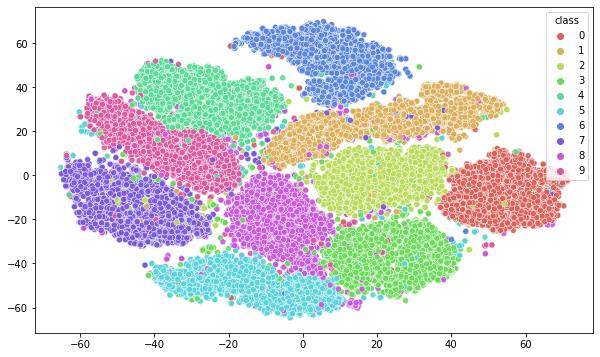

In [18]:
tsne_2d_one = X_2d[:,0]
tsne_2d_two = X_2d[:,1]
plt.figure(figsize=(10,6))
sns.scatterplot(
    x=tsne_2d_one, y=tsne_2d_two,
    hue=yy,
    palette=sns.color_palette("hls", 10),
    data=Xx,
    legend="full",
    alpha=0.9
);

In [19]:
clustering_X_2d = AgglomerativeClustering(n_clusters=10).fit_predict(X_2d)
print(f'V score AC: {metrics.v_measure_score(clustering_X_2d, yy)}')
print(f'Silhouette score AC: {metrics.silhouette_score(X_2d, clustering_X_2d)}')
print(' ')
kmeans_X_2d = KMeans(n_clusters=10, n_init=100, random_state=42).fit(X_2d)
labels_X_2d = kmeans_X_2d.labels_
print(f'V score Kmeans: {metrics.v_measure_score(labels_X_2d, yy)}')
print(f'Silhouette score Kmeans: {metrics.silhouette_score(X_2d, labels_X_2d)}')

V score AC: 0.8217169187735263
Silhouette score AC: 0.38934946060180664
 
V score Kmeans: 0.7602940717864537
Silhouette score Kmeans: 0.4246794283390045


Clustering visually seems quite accurate, after dimensionality reduction with t-SNE (n_components = 2) the best silhouette value = 0.82 (AgglomerativeClustering (n_clusters = 10)), and 𝑉 -measures = 0.42 (KMeans (n_clusters = 10)).